# Visualize the Attention of the Models

In [2]:
path = "/nfs/home/sveng/logs/tmp/opt_a-transformer_l-sharpe_ty-2000_bs-128_lr-0.01_pa-25_gn-0.5_wl-63_ws-63_nl-1_dh-10_dr-0.1_dm-20_nh-4.p"

In [1]:
path = "/nfs/home/sveng/logs/random_sharpe_transformer/11_06_2021/opt_a-transformer_l-sharpe_ty-1995_bs-64_lr-0.001_pa-25_gn-0.0001_wl-63_ws-63_nl-1_dh-256_dr-0.1_dm-128_nh-8.p"

In [2]:
import numpy as np
import pandas as pd
import pickle
import torch
from torch.utils.data import DataLoader
from libs.data_loader import BaseDataLoader, DataTypes
import matplotlib.pyplot as plt
import seaborn as sns

from libs.data_loader import BaseDataLoader, DataTypes
from libs.futures_dataset import FuturesDataset

## Load Model & Data

In [3]:
train_dict = pickle.load(open(path, 'rb'))
model = train_dict['model']
train_manager = train_dict['train_manager']

# --- ---

index_col = 0

base_loader = BaseDataLoader(
    filename=train_manager['args']['filename'], index_col=index_col, start_date=train_manager['args']['start_date'], end_date=train_manager['args']['end_date'], test_date=train_manager['args']['test_date'], lead_target=train_manager['args']['lead_target'])

dataset_test = FuturesDataset(
    base_loader, DataTypes.TEST, win_size=train_manager['args']['win_len'], tau=train_manager['args']['lead_target'], step=train_manager['args']['step'], scaler=train_manager['args']['scaler'])
test_dataloader = DataLoader(
    dataset_test, batch_size=train_manager['args']['batch_size'], shuffle=False)

> Load raw datset (futures_prop.csv)
> Filtered out series: 
> Winzorizing [3, 3, 3, 1, 1] values at:             [ZR_close, NR_close, ZO_close, ZP_close, BN_close] (threshold: 5)
> Calculate covariates
> No additional scaling used


## Plot Predictions

In [4]:
attn_i = dataset_test.plot_example(90, model=model, loss_type=train_manager['loss_type'])

RuntimeError: The size of the 3D attn_mask is not correct.

## Visualize Attention

In [5]:
attn = dataset_test.get_attention(id=1, model=model).detach().cpu().numpy()[0, :, :, :]

<AxesSubplot:>

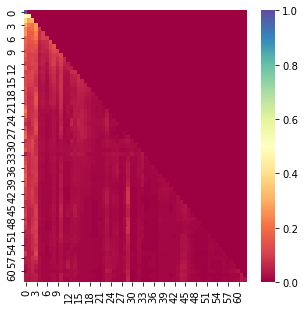

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(attn[0, :, :], ax=ax, cmap="Spectral")

In [7]:
y = dataset_test[0]['prs'].squeeze().cpu().numpy()
sns.lineplot(y=y, x=range(63), color="black")
ax2 = plt.twinx()
y_attn = np.flip(attn[0, :, 0], axis=-1)
sns.lineplot(x=range(63), y=y_attn, ax=ax2, color="red")

ValueError: Data must be 1-dimensional

In [31]:
def plot_attention_line(model, data_iter=dataset_test, id=None, step=2, n_color=5, n_layer=0):
    if id is None:
        # randomize
        sample_size = len(data_iter)
        id = int(np.random.uniform(0, sample_size))
    
    attn = data_iter.get_attention(id=id, model=model).detach().cpu().numpy()[0, :, :, :]
    attn = attn / np.sum(attn)
    inst = dataset_test[id]['inst']
    t_0 = dataset_test[id]['time'] # tmp

    # tmp
    pred = ((1 + data_iter[id]['trg'][-1]) * data_iter[id]['prs'][-1]).cpu().numpy()

    print(data_iter[id]['prs'].shape)

    # build df ----
    df_plot = pd.DataFrame({
        'prs': data_iter[id]['prs'][:, 0].squeeze().cpu().numpy(),
        'prs_lead': data_iter[id]['prs'][:, 1].squeeze().cpu().numpy(),
        'attn': np.flip(attn[n_layer, :, 0], axis=-1)
    })
    df_plot['t'] = range(df_plot.shape[0])
    df_plot['t_group'] = pd.qcut(df_plot['t'], int(63/step), labels=False)
    df_plot['attn_mean'] = df_plot['attn'].groupby(df_plot['t_group']).transform('mean')
    df_plot['attn_group'] = pd.qcut(df_plot['attn_mean'], n_color, labels=False)

    # plot ----
    fig, ax = plt.subplots(1,1)
    cmap = plt.get_cmap(name='viridis', lut=n_color)
    for i in range(0, 63+1, step):
        # ... in segments ----
        group = df_plot.iloc[i:(i+step+1),:]
        attn_i = group.iloc[0, -1]
        color = cmap(attn_i)
        ax.plot(group['t'], group['prs'], color=color, markeredgewidth=1.5, zorder=0, marker=".")
        ax.plot(group['t'], group['prs'], color=color, linewidth=2.5, zorder=2)

    # prediction point
    ax.scatter(df_plot['t'].iat[-1]+1, df_plot['prs_lead'].iat[-1], marker="x", color="red")

    # raw
    ax2 = ax.twinx()
    ax2.plot(df_plot['t'], df_plot['attn'], '--', zorder=1, color="black")

    # labels, ..
    ax.set_xlabel('t')
    ax.set_ylabel('price')
    ax2.set_ylabel('attention')
    ax.set_title(inst)
    fig.show()

torch.Size([63, 2])


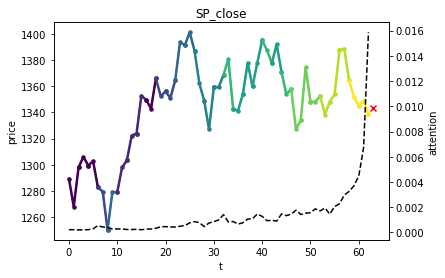

In [33]:
plot_attention_line(model=model, data_iter=dataset_test, step=2, n_color=10)

In [35]:
dataset_test

In [ ]:
# TBD: add actual date!
# TBD: add actual trg price (not approximated by return!)

In [31]:
tmp = pd.DataFrame={'x1': [1,2,3], 'x2':[2,4,5]}
tmp['x2']
